In [1]:
import sys

if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = [sys.argv[0]]

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from src.models import *
from src.constants import *
from src.plotting import *
from src.pot import pot_eval
from src.utils import *
from src.diagnosis import *
from src.merlin import *
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
from time import time
from pprint import pprint
import seaborn as sns
import mlflow

import warnings
warnings.filterwarnings('ignore')

Using backend: pytorch


### Importing data

In [3]:
columns = [
    'data:zone_air_heating_temperature_setpoint', 
    'data:zone_air_temperature_sensor', 
    'data:zone_air_cooling_temperature_setpoint', 
    'data:supply_air_flowrate_sensor', 
    'data:supply_air_damper_percentage_command', 
    'data:supply_air_flowrate_setpoint', 
    'dow',
    'hod',
    'class_label']

df = pd.read_csv('data/anomaly_detection_sample_1577622599.csv', usecols=columns)

new_column_names = [
    'heating_setpoint', 
    'air_temperature', 
    'cooling_setpoint', 
    'supply_flowrate', 
    'damper_percentage', 
    'flowrate_setpoint', 
    'day_of_week', 
    'hour_of_day', 
    'label'
]

df.columns = new_column_names

df['label'] = df['label'].replace({0: 1, 1: 0})

df.head()

heating_setpoint  air_temperature  cooling_setpoint  supply_flowrate  \
0        294.259259       296.037037        297.037037         0.044528   
1        294.259259       294.925926        297.037037         0.203740   
2        294.259259       296.648148        297.037037         0.036790   
3        294.259259       296.425926        297.037037         0.154288   
4        294.259259       296.092593        297.037037         0.178737   

   damper_percentage  flowrate_setpoint  day_of_week  hour_of_day  label  
0          47.265250           0.037756            0           17      0  
1           4.489845           0.188779            0           17      0  
2          20.409615           0.035396            0           17      0  
3          37.755330           0.151023            0           17      0  
4          16.167740           0.169901            0           17      0

### Data Preparation

In [4]:
X = df.drop(['day_of_week', 'hour_of_day', 'label'], axis=1)
# X = df.drop(['label'], axis=1)
y = df['label']

X_train, X_test, y_test = X.iloc[:27113, :], X.iloc[27113:, :], y.iloc[27113:]

X_train = X_train.values
X_test = X_test.values

### Sample data (First day: train, second day: test)
steps_per_day = X_test.shape[0] // 7 

sample_train = X_test[:steps_per_day]
sample_test = X_test[steps_per_day:steps_per_day*2]

def normalize(a, min_a = None, max_a = None):
	if min_a is None: min_a, max_a = np.min(a, axis = 0), np.max(a, axis = 0)
	return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

train, min_a, max_a = normalize(sample_train)
test, _, _ = normalize(sample_test, min_a, max_a)

labels = np.repeat(y_test[:, np.newaxis], repeats=test.shape[1], axis=1)
labels = labels.astype(float)

labels = labels[steps_per_day:steps_per_day*2]

In [5]:
train.shape, test.shape, labels.shape

((4758, 6), (4758, 6), (4758, 6))

### Functions

In [6]:
### Windows functions
def convert_to_windows(data, model):
	windows = []; w_size = model.n_window
	for i, g in enumerate(data): 
		if i >= w_size: w = data[i-w_size:i]
		else: w = torch.cat([data[0].repeat(w_size-i, 1), data[0:i]])
		windows.append(w)
	return torch.stack(windows)

### Dataloader
def data_loader(train, test, labels):
	train_loader = DataLoader(train, batch_size=train.shape[0])
	test_loader = DataLoader(test, batch_size=test.shape[0])
	labels_loader = labels
	return train_loader, test_loader, labels_loader

### Model
def create_model(modelname, dims):
	import src.models
	model_class = getattr(src.models, modelname)
	model = model_class(dims).double()

	optimizer = torch.optim.AdamW(model.parameters() , lr=model.lr, weight_decay=1e-5)
	scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.9)

	print(f"{color.GREEN}Creating new model: {model.name}{color.ENDC}")
	
	epoch = -1
	accuracy_list = []

	return model, optimizer, scheduler, epoch, accuracy_list

### Training
def backprop(epoch, model, data, dataO, optimizer, scheduler, training = True):
    feats = dataO.shape[1]
    l = nn.MSELoss(reduction = 'none')
    
    data_x = torch.DoubleTensor(data); dataset = TensorDataset(data_x, data_x)
    bs = model.batch if training else len(data)
    dataloader = DataLoader(dataset, batch_size = bs)
    n = epoch + 1; w_size = model.n_window
    l1s, l2s = [], []
    if training:
        for d, _ in dataloader:
            local_bs = d.shape[0]
            window = d.permute(1, 0, 2)
            elem = window[-1, :, :].view(1, local_bs, feats)
            z = model(window, elem)
            l1 = l(z, elem) if not isinstance(z, tuple) else (1 / n) * l(z[0], elem) + (1 - 1/n) * l(z[1], elem)
            if isinstance(z, tuple): z = z[1]
            l1s.append(torch.mean(l1).item())
            loss = torch.mean(l1)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
        scheduler.step()
        tqdm.write(f'Epoch {epoch},\tL1 = {np.mean(l1s)}')
        return np.mean(l1s), optimizer.param_groups[0]['lr']
    else:
        for d, _ in dataloader:
            window = d.permute(1, 0, 2)
            elem = window[-1, :, :].view(1, bs, feats)
            z = model(window, elem)
            if isinstance(z, tuple): z = z[1]
        loss = l(z, elem)[0]
        return loss.detach().numpy(), z.detach().numpy()[0]

In [7]:
train_loader, test_loader, labels_loader = data_loader(train, test, labels)

model, optimizer, scheduler, epoch, loss_list = create_model('TranAD', labels_loader.shape[1])

## Prepare data
trainD, testD = next(iter(train_loader)), next(iter(test_loader))
trainO, testO = trainD, testD 

trainD, testD = convert_to_windows(trainD, model), convert_to_windows(testD, model)

Creating new model: TranAD


### Experiment Tracking

In [8]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("TranAD on Smart building dataset")

<Experiment: artifact_location='mlflow-artifacts:/945510866311899735', creation_time=1723717675457, experiment_id='945510866311899735', last_update_time=1723717675457, lifecycle_stage='active', name='TranAD on Smart building dataset', tags={}>

In [9]:
import gc
gc.collect()

399

  0%|          | 0/50 [00:00<?, ?it/s]

Creating new model: TranAD
Training TranAD on external dataset.


  2%|▏         | 1/50 [00:01<00:59,  1.21s/it]

Epoch 0,	L1 = 0.16243421349725026


  4%|▍         | 2/50 [00:02<00:59,  1.24s/it]

Epoch 1,	L1 = 0.1487513315790658


  6%|▌         | 3/50 [00:03<00:56,  1.20s/it]

Epoch 2,	L1 = 0.1384173956018139


  8%|▊         | 4/50 [00:04<00:54,  1.19s/it]

Epoch 3,	L1 = 0.12924779901838732


 10%|█         | 5/50 [00:05<00:52,  1.16s/it]

Epoch 4,	L1 = 0.12077925171871184


 12%|█▏        | 6/50 [00:07<00:50,  1.15s/it]

Epoch 5,	L1 = 0.11378113776917836


 14%|█▍        | 7/50 [00:08<00:49,  1.15s/it]

Epoch 6,	L1 = 0.10818600984974562


 16%|█▌        | 8/50 [00:09<00:48,  1.15s/it]

Epoch 7,	L1 = 0.10270382487447817


 18%|█▊        | 9/50 [00:10<00:47,  1.15s/it]

Epoch 8,	L1 = 0.09770410459004347


 20%|██        | 10/50 [00:11<00:45,  1.13s/it]

Epoch 9,	L1 = 0.09334738023284324


 22%|██▏       | 11/50 [00:12<00:44,  1.13s/it]

Epoch 10,	L1 = 0.08866261803167969


 24%|██▍       | 12/50 [00:13<00:42,  1.12s/it]

Epoch 11,	L1 = 0.08561530854870632


 26%|██▌       | 13/50 [00:14<00:41,  1.12s/it]

Epoch 12,	L1 = 0.08168657039651814


 28%|██▊       | 14/50 [00:16<00:40,  1.12s/it]

Epoch 13,	L1 = 0.07849892304266715


 30%|███       | 15/50 [00:17<00:38,  1.11s/it]

Epoch 14,	L1 = 0.07548666468568714


 32%|███▏      | 16/50 [00:18<00:37,  1.10s/it]

Epoch 15,	L1 = 0.07203749187972637


 34%|███▍      | 17/50 [00:19<00:36,  1.10s/it]

Epoch 16,	L1 = 0.06843544765253419


 36%|███▌      | 18/50 [00:20<00:35,  1.11s/it]

Epoch 17,	L1 = 0.06576057799493872


 38%|███▊      | 19/50 [00:21<00:34,  1.10s/it]

Epoch 18,	L1 = 0.06303958891099119


 40%|████      | 20/50 [00:22<00:33,  1.11s/it]

Epoch 19,	L1 = 0.060808603985270146


 42%|████▏     | 21/50 [00:23<00:32,  1.10s/it]

Epoch 20,	L1 = 0.05775652758515828


 44%|████▍     | 22/50 [00:24<00:31,  1.11s/it]

Epoch 21,	L1 = 0.05548768535537968


 46%|████▌     | 23/50 [00:25<00:30,  1.11s/it]

Epoch 22,	L1 = 0.05358947948480797


 48%|████▊     | 24/50 [00:27<00:28,  1.11s/it]

Epoch 23,	L1 = 0.05213425102672958


 50%|█████     | 25/50 [00:28<00:27,  1.10s/it]

Epoch 24,	L1 = 0.049779845304431525


 52%|█████▏    | 26/50 [00:29<00:26,  1.11s/it]

Epoch 25,	L1 = 0.04888745375362005


 54%|█████▍    | 27/50 [00:30<00:25,  1.12s/it]

Epoch 26,	L1 = 0.047489723951976724


 56%|█████▌    | 28/50 [00:31<00:24,  1.12s/it]

Epoch 27,	L1 = 0.04629631899109209


 58%|█████▊    | 29/50 [00:32<00:23,  1.12s/it]

Epoch 28,	L1 = 0.04508915637572116


 60%|██████    | 30/50 [00:33<00:22,  1.12s/it]

Epoch 29,	L1 = 0.043940683481808955


 62%|██████▏   | 31/50 [00:34<00:21,  1.11s/it]

Epoch 30,	L1 = 0.043185797497450266


 64%|██████▍   | 32/50 [00:36<00:20,  1.11s/it]

Epoch 31,	L1 = 0.042144870537643396


 66%|██████▌   | 33/50 [00:37<00:18,  1.11s/it]

Epoch 32,	L1 = 0.0419259488135148


 68%|██████▊   | 34/50 [00:38<00:17,  1.11s/it]

Epoch 33,	L1 = 0.04120377117158183


 70%|███████   | 35/50 [00:39<00:16,  1.11s/it]

Epoch 34,	L1 = 0.040567563840418874


 72%|███████▏  | 36/50 [00:40<00:15,  1.12s/it]

Epoch 35,	L1 = 0.040341712797280514


 74%|███████▍  | 37/50 [00:41<00:14,  1.11s/it]

Epoch 36,	L1 = 0.03940994178357118


 76%|███████▌  | 38/50 [00:42<00:13,  1.11s/it]

Epoch 37,	L1 = 0.03894604848062115


 78%|███████▊  | 39/50 [00:43<00:12,  1.11s/it]

Epoch 38,	L1 = 0.03866375910851063


 80%|████████  | 40/50 [00:44<00:11,  1.11s/it]

Epoch 39,	L1 = 0.03802953562316913


 82%|████████▏ | 41/50 [00:45<00:09,  1.11s/it]

Epoch 40,	L1 = 0.03769052607535843


 84%|████████▍ | 42/50 [00:47<00:08,  1.11s/it]

Epoch 41,	L1 = 0.0370189388602211


 86%|████████▌ | 43/50 [00:48<00:07,  1.11s/it]

Epoch 42,	L1 = 0.03677146196526383


 88%|████████▊ | 44/50 [00:49<00:06,  1.11s/it]

Epoch 43,	L1 = 0.036495302537785566


 90%|█████████ | 45/50 [00:50<00:05,  1.10s/it]

Epoch 44,	L1 = 0.03590482638334852


 92%|█████████▏| 46/50 [00:51<00:04,  1.11s/it]

Epoch 45,	L1 = 0.0360671901349424


 94%|█████████▍| 47/50 [00:52<00:03,  1.11s/it]

Epoch 46,	L1 = 0.035764789671178285


 96%|█████████▌| 48/50 [00:53<00:02,  1.11s/it]

Epoch 47,	L1 = 0.03542253069246824


 98%|█████████▊| 49/50 [00:54<00:01,  1.11s/it]

Epoch 48,	L1 = 0.034907768710235786


100%|██████████| 50/50 [00:55<00:00,  1.12s/it]


Epoch 49,	L1 = 0.03490258809450768
Training time:    55.9915 s


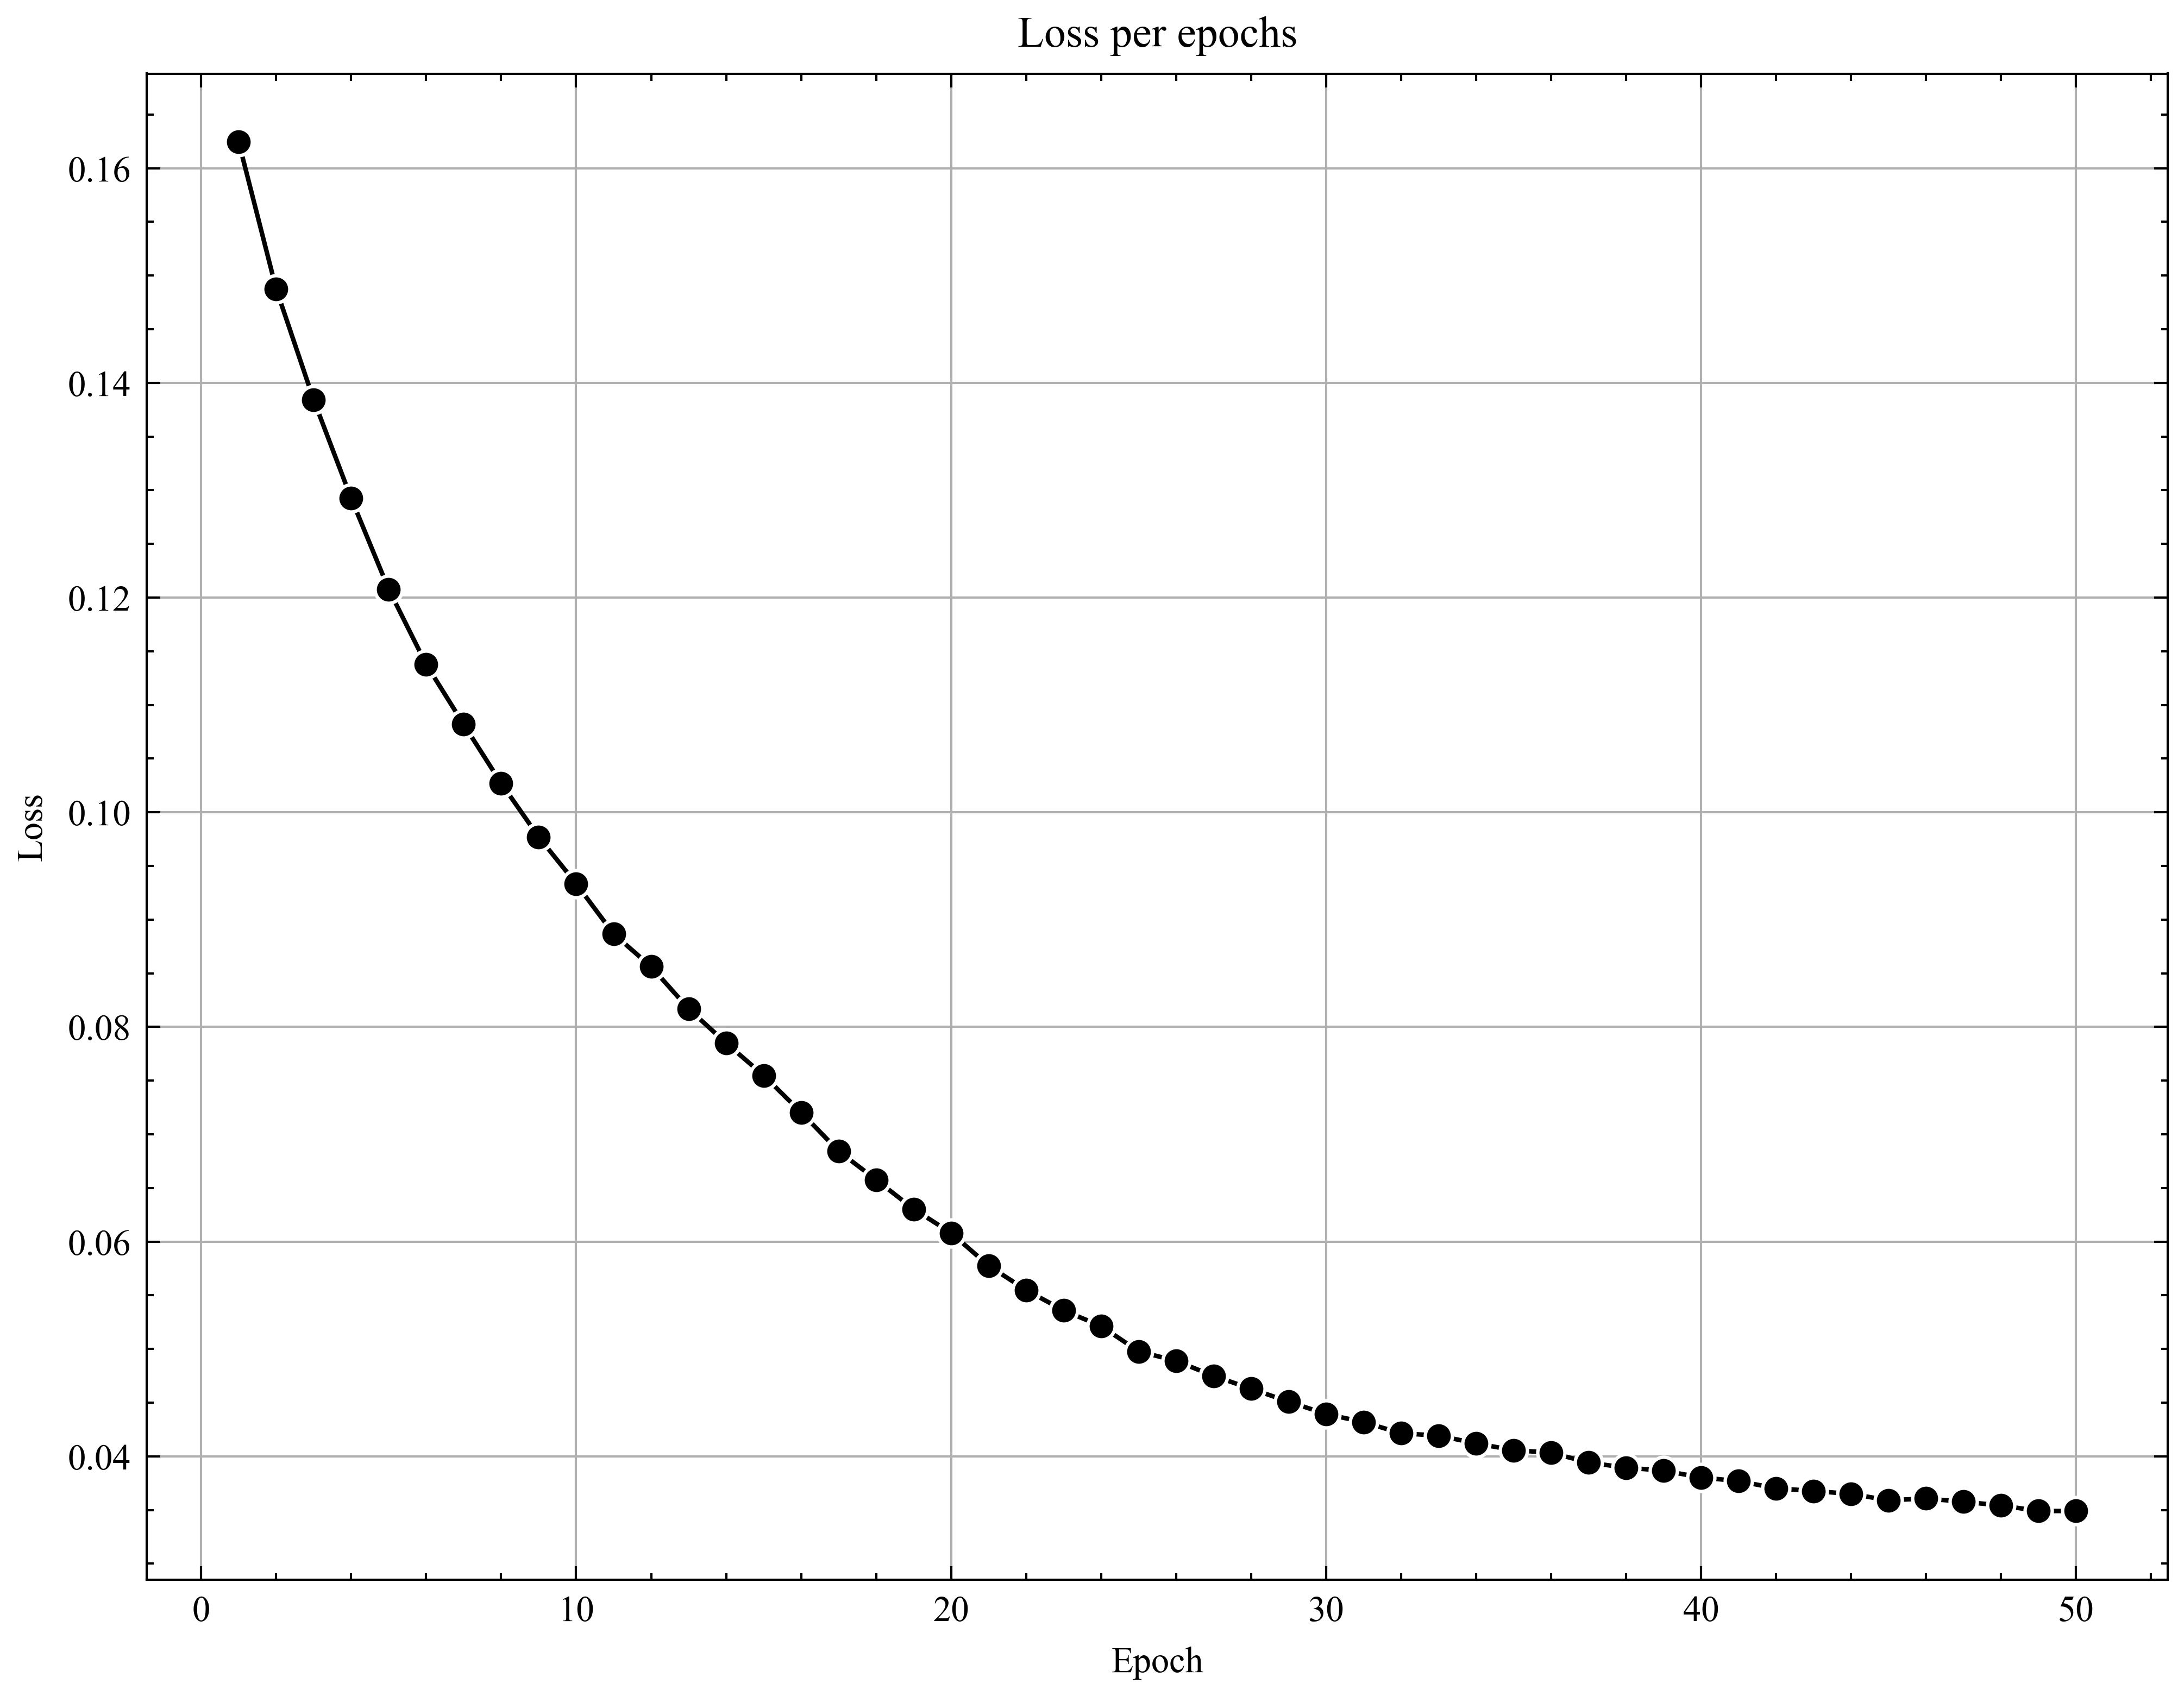

Testing TranAD on SBD dataset


FN     FP   ROC/AUC      TN    TP        f1  precision    recall  \
0  255.0    0.0  0.500000  4503.0   0.0  0.000000   0.000000  0.000000   
1  247.0   90.0  0.505693  4413.0   8.0  0.045322   0.081633  0.031373   
2  255.0  265.0  0.470575  4238.0   0.0  0.000000   0.000000  0.000000   
3  249.0    6.0  0.511098  4497.0   6.0  0.044943   0.500000  0.023529   
4  255.0   45.0  0.495003  4458.0   0.0  0.000000   0.000000  0.000000   
5  245.0    8.0  0.518720  4495.0  10.0  0.073259   0.555555  0.039216   

   threshold  
0   0.511801  
1   0.137443  
2   0.099338  
3   0.137808  
4   0.292176  
5   0.179429

{'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'TP': 0, 'TN': 4502, 'FP': 1, 'FN': 255, 'ROC/AUC': 0.4998889629136131, 'threshold': 0.1808396192574138, 'Hit@100%': 1.0, 'Hit@150%': 1.0, 'NDCG@100%': 1.0, 'NDCG@150%': 1.0}


2024/08/15 20:00:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 11_changing_lm at: http://localhost:5000/#/experiments/945510866311899735/runs/5bcaf56de5c142e39b5e57b2af3de845.
2024/08/15 20:00:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/945510866311899735.


In [10]:
RUN_NAME = '11_changing_lm'

with mlflow.start_run(run_name=RUN_NAME):
    ### Hyperparameters
    params = {
        'lr': 0.0001,
        'batch_size': 128,
        'epochs': 50,
        'window_size': 10,
        'lm': (0.989, 1.03)
    }

    model, optimizer, scheduler, epoch, loss_list = create_model('TranAD', labels_loader.shape[1])

    ### Training phase
    print(f'{color.HEADER}Training TranAD on external dataset.{color.ENDC}')
    num_epochs = params['epochs']; e = epoch + 1; start = time()
    for e in tqdm(list(range(epoch+1, epoch+num_epochs+1))):
        lossT, lr = backprop(e, model, trainD, trainO, optimizer, scheduler)
        loss_list.append((lossT, lr))
    print(color.BOLD+'Training time: '+"{:10.4f}".format(time()-start)+' s'+color.ENDC)

    mlflow.log_params(params)

    ### Training loss plot
    epochs = list(range(1, len(loss_list) + 1))
    loss = [l[0] for l in loss_list]

    plt.figure(figsize=(8, 6))
    sns.lineplot(x=epochs, y=loss, marker='o')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per epochs')
    plt.grid(True)

    mlflow.log_figure(plt.gcf(), "training loss.png")

    plt.show()

    ### Testing phase
    torch.zero_grad = True
    model.eval()
    preds = []
    print(f'{color.HEADER}Testing TranAD on SBD dataset{color.ENDC}')
    loss, y_pred = backprop(0, model, testD, testO, optimizer, scheduler, training=False)

    df = pd.DataFrame()
    lossT, _ = backprop(0, model, trainD, trainO, optimizer, scheduler, training=False)
    for i in range(loss.shape[1]):
        lt, l, ls = lossT[:, i], loss[:, i], labels_loader[:, i]
        result, pred = pot_eval(lt, l, ls) 
        preds.append(pred)
        df = df.append(result, ignore_index=True)

    lossTfinal, lossFinal = np.mean(lossT, axis=1), np.mean(loss, axis=1)
    labelsFinal = (np.sum(labels_loader, axis=1) >= 1) + 0
    result, _ = pot_eval(lossTfinal, lossFinal, labelsFinal)
    result.update(hit_att(loss, labels_loader))
    result.update(ndcg(loss, labels_loader))
    display(df)
    print(result)

    mlflow.log_metric("AUC", result['ROC/AUC'])
    mlflow.log_metric("Precision", result['precision'])
    mlflow.log_metric("Recall", result['recall'])
    mlflow.log_metric("F1", result['f1'])
    mlflow.log_metric("Threshold", result['threshold'])

    ### Results plot
    final_preds = np.array([[np.float32(value) for value in sublist] for sublist in preds]).T

    test_data = test
    true_labels = labels
    predicted_labels = final_preds

    channels = np.arange(0, 6)
    channel_len = len(channels)

    # Plotting
    fig, axes = plt.subplots(channel_len*2, 1, figsize=(15, channel_len*4), sharex=True)
    time_steps = np.arange(test_data.shape[0])

    for i, axes_i in enumerate(range(0, channel_len*2, 2)):
        channel = channels[i]
        axes[axes_i].plot(time_steps, test_data[:, channel], label='original data')
        axes[axes_i].plot(time_steps, y_pred[:, channel], label='predicted data')
        axes[axes_i].fill_between(time_steps, 0, 1, where=true_labels[:, channel] == 1, color='red', alpha=0.5, label='true anomaly')
        axes[axes_i].set_title(f'Channel {channel}', fontsize=12)
        axes[axes_i].set_xlabel('Time', fontsize=10)
        axes[axes_i].set_ylabel('Value', fontsize=10)
        axes[axes_i].grid(True)
        axes[axes_i].legend()

        axes[axes_i + 1].plot(time_steps, loss[:, channel], color='green', label='anomaly score')
        axes[axes_i + 1].fill_between(time_steps, 0, 1, where=predicted_labels[:, channel] == 1, color='blue', alpha=0.5, label='predicted anomaly')
        axes[axes_i + 1].set_title(f'Channel {channel} - Anomaly Score', fontsize=12)
        axes[axes_i + 1].set_xlabel('Time', fontsize=10)
        axes[axes_i + 1].set_ylabel('Value', fontsize=10)
        axes[axes_i + 1].grid(True)
        axes[axes_i + 1].legend()

    fig.suptitle('Testing data with true anomaly and predicted anomaly', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    mlflow.log_figure(fig, "result.png")